In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

In [2]:
X_train_eng = pd.read_csv('data/X_train_eng.csv', index_col = 'id')
X_test_eng = pd.read_csv('data/X_test_eng.csv', index_col = 'id')
y_train_eng = pd.read_csv('data/y_train_eng.csv', index_col = 'id')
y_test_eng = pd.read_csv('data/y_test_eng.csv', index_col = 'id')

In [3]:
holdout = pd.read_csv('data/holdout_data.csv')

In [4]:
def log_loss(model, X=None, y=None, scoring='neg_log_loss', cv=3):
    log_loss = cross_val_score(model, X, y, scoring=scoring, cv=cv)
    log_loss = -log_loss.mean()
    print(f'Log loss: {log_loss}')

In [5]:
def model_predictions(model, X=None, y=None):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    func = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
    func_nr = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
    non_func = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
    print(f'The model correctly predicts {round(func*100, 2)}% of the funtional wells.')
    print(f'The model correctly predicts {round(func_nr*100, 2)}% of the funtional-needs-repair wells.')
    print(f'The model correctly predicts {round(non_func*100, 2)}% of the non-functional wells.')

In [6]:
X_train_cat = X_train_eng.select_dtypes('object')
X_train_num = X_train_eng.select_dtypes(['float64', 'int64'])

cat_pipe = Pipeline(steps = [
    ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])
num_pipe = Pipeline(steps = [
    ('imp', SimpleImputer(missing_values=0, strategy='median')),
    ('ss', StandardScaler()),
])

transformer = ColumnTransformer([('categorical', cat_pipe, X_train_cat.columns), 
                                  ('numerical', num_pipe, X_train_num.columns)])

# Using The SVM Model

We are going to use the SVM model with no hyperparameter tuning since it has the best combined score of functional needs repair and non functional wells.

In [7]:
y_train_eng = y_train_eng['status_group']
y_test_eng = y_test_eng['status_group']

In [8]:
svm_pipe = imbPipeline([
    ('trans', transformer), 
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC())
])
svm_pipe.fit(X_train_eng, y_train_eng)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['installer', 'basin', 'public_meeting', 'scheme_management', 'permit',
       'management', 'payment', 'quantity'],
      dtype='object')),
                                                 ('numerical...
                                                                  ('ss',
               

In [9]:
print('Accuracy Score Train:', svm_pipe.score(X_train_eng,y_train_eng))
print('Accuracy Score Test:', svm_pipe.score(X_test_eng,y_test_eng))

Accuracy Score Train: 0.6854111935086961
Accuracy Score Test: 0.6565243415802074


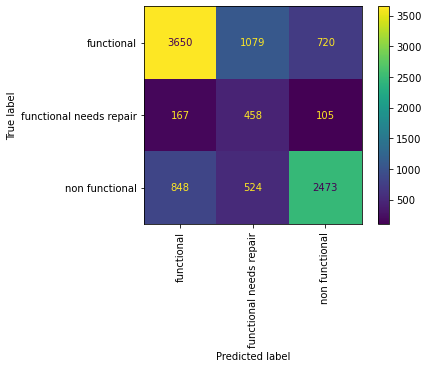

In [10]:
plot_confusion_matrix(svm_pipe, X_test_eng, y_test_eng, xticks_rotation='vertical');

In [11]:
model_predictions(svm_pipe, X_test_eng, y_test_eng)

The model correctly predicts 66.98% of the funtional wells.
The model correctly predicts 62.74% of the funtional-needs-repair wells.
The model correctly predicts 64.32% of the non-functional wells.


# Using Random Forest Model

In [12]:
model_pipe_4 = imbPipeline(steps=[
    ('trans', transformer),
    ('smote', SMOTE(random_state=42)),
    ('rfc', RandomForestClassifier(verbose=1, n_jobs=-2, 
                                   criterion = 'entropy',
                                   max_depth = 80,
                                   min_samples_leaf = 2,
                                   min_samples_split = 2,
                                   n_estimators = 250,
                                   class_weight='balanced'))])

In [13]:
model_pipe_4.fit(X_train_eng, y_train_eng)

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-2)]: Done 250 out of 250 | elapsed:    9.9s finished


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['installer', 'basin', 'public_meeting', 'scheme_management', 'permit',
       'management', 'payment', 'quantity'],
      dtype='object')),
                                                 ('numerical...
       'population', 'construction_year', 'water_quality_by_region',
       'water_quali

In [14]:
model_pipe_4.score(X_train_eng, y_train_eng)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.2s
[Parallel(n_jobs=7)]: Done 250 out of 250 | elapsed:    0.3s finished


0.8861028898274085

In [15]:
model_pipe_4.score(X_test_eng, y_test_eng)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 250 out of 250 | elapsed:    0.1s finished


0.7549880287310455

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 250 out of 250 | elapsed:    0.1s finished


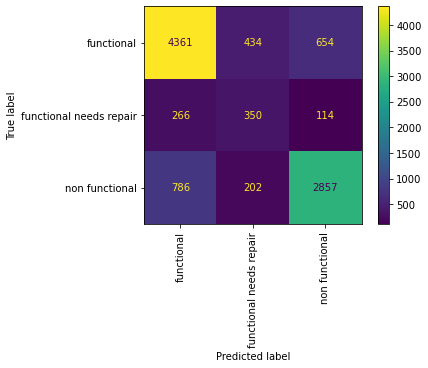

In [16]:
plot_confusion_matrix(model_pipe_4, X_test_eng, y_test_eng, xticks_rotation='vertical');

In [17]:
model_predictions(model_pipe_4, X_test_eng, y_test_eng)

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 250 out of 250 | elapsed:    0.1s finished


The model correctly predicts 80.03% of the funtional wells.
The model correctly predicts 47.95% of the funtional-needs-repair wells.
The model correctly predicts 74.3% of the non-functional wells.


# Using the holdout data to see which model is better

In [18]:
# Import the presplit data
X_train = pd.read_csv('data/X_train.csv', index_col='id')
X_test = pd.read_csv('data/X_test.csv', index_col='id')
y_train = pd.read_csv('data/y_train.csv', index_col='id')
y_test = pd.read_csv('data/y_test.csv', index_col='id')

In [19]:
X_train_cat = X_train.select_dtypes('object')
X_train_num = X_train.select_dtypes(['float64', 'int64'])

cat_pipe = Pipeline(steps = [
    ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])
num_pipe = Pipeline(steps = [
    ('imp', SimpleImputer(missing_values=0, strategy='median')),
    ('ss', StandardScaler()),
])

transformer = ColumnTransformer([('categorical', cat_pipe, X_train_cat.columns), 
                                  ('numerical', num_pipe, X_train_num.columns)])

## Using SVM to fit the data

In [20]:
y_train = y_train['status_group']
y_test = y_test['status_group']

In [21]:
svm_pipe = imbPipeline([
    ('trans', transformer), 
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC())
])
svm_pipe.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['installer', 'basin', 'region', 'public_meeting', 'scheme_management',
       'permit', 'extraction_type', 'management', 'payment', 'water_quality',
       'quantity', 'source', 'waterpoint_type'],
      dtype='object')),
                                                 ('numerical',
       

## Using Random Forest to fit the data

In [22]:
model_pipe_4 = imbPipeline(steps=[
    ('trans', transformer),
    ('smote', SMOTE(random_state=42)),
    ('rfc', RandomForestClassifier(verbose=1, n_jobs=-2, 
                                   criterion = 'entropy',
                                   max_depth = 80,
                                   min_samples_leaf = 2,
                                   min_samples_split = 2,
                                   n_estimators = 250,
                                   class_weight='balanced'))])
model_pipe_4.fit(X_train, y_train)

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-2)]: Done 250 out of 250 | elapsed:   15.6s finished


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['installer', 'basin', 'region', 'public_meeting', 'scheme_management',
       'permit', 'extraction_type', 'management', 'payment', 'water_qualit...
                                                                                 strategy='median')),
                                         

In [23]:
X_test_holdout = holdout.drop('status_group', axis=1)
y_test_holdout = holdout[['status_group']]

# Scoring the SVM and Random Forest on the Holdout data

## SVM Model

In [24]:
print('Accuracy Score Test:', svm_pipe.score(X_test_holdout, y_test_holdout))

C:\Users\Manav Kahlon\anaconda3\envs\learn-env\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


Accuracy Score Test: 0.7129629629629629


C:\Users\Manav Kahlon\anaconda3\envs\learn-env\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


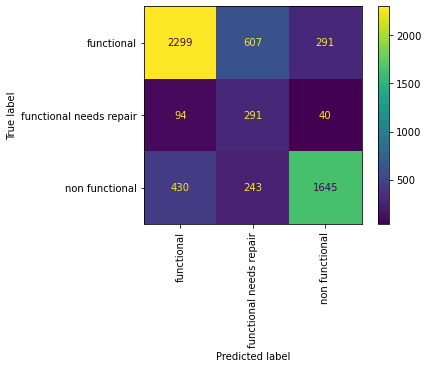

In [25]:
plot_confusion_matrix(svm_pipe, X_test_holdout, y_test_holdout, xticks_rotation='vertical');

In [26]:
model_predictions(svm_pipe, X_test_holdout, y_test_holdout)

C:\Users\Manav Kahlon\anaconda3\envs\learn-env\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


The model correctly predicts 71.91% of the funtional wells.
The model correctly predicts 68.47% of the funtional-needs-repair wells.
The model correctly predicts 70.97% of the non-functional wells.


## Random Forest Model

In [27]:
print('Accuracy Score Test:', model_pipe_4.score(X_test_holdout, y_test_holdout))

Accuracy Score Test: 0.7823232323232323


C:\Users\Manav Kahlon\anaconda3\envs\learn-env\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 250 out of 250 | elapsed:    0.0s finished


C:\Users\Manav Kahlon\anaconda3\envs\learn-env\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 250 out of 250 | elapsed:    0.0s finished


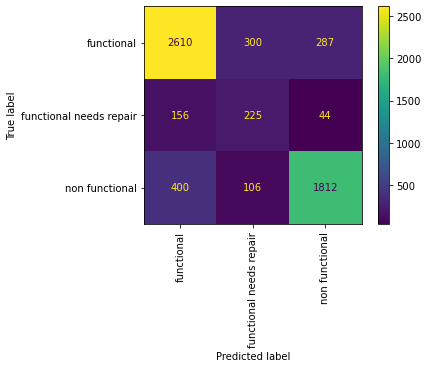

In [28]:
plot_confusion_matrix(model_pipe_4, X_test_holdout, y_test_holdout, xticks_rotation='vertical');

In [29]:
model_predictions(model_pipe_4, X_test_holdout, y_test_holdout)

C:\Users\Manav Kahlon\anaconda3\envs\learn-env\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 250 out of 250 | elapsed:    0.1s finished


The model correctly predicts 81.64% of the funtional wells.
The model correctly predicts 52.94% of the funtional-needs-repair wells.
The model correctly predicts 78.17% of the non-functional wells.
